# Step 0: imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import math, random

import encode, source, output, additions
from note import Note

%matplotlib inline

# Step 1: target function
We import the notes of a tune to use as our target pitches and define a function that returns the target frequency given the current time.

In [109]:
song = pd.read_csv('music_notes/loch_lomond.csv')
song.columns = [c.strip() for c in song.columns.values]
songnotes = song.loc[:50,['pitch (as sharps)', 'octave']]
llnotes = []
for i in range(songnotes.shape[0]):
    note = songnotes.iloc[i]['pitch (as sharps)']
    octave = int(songnotes.iloc[i]['octave'])
    llnotes.append(Note(note).at_octave(octave))
ll_freq = [n.frequency() for n in llnotes]
# fix initial note repeats
ll_freq = ll_freq[3:]

def get_target(index):
    ''' Takes the index of the current target note
        and returns the target frequency of that note
    '''
    return ll_freq[index]

# Step 2: error function
We measure the error of the current pitch vs the target

In [110]:
def get_error(target, current):
    ''' Calculates current error in order to
        inform a control routine
    '''
    return target - current

# Step 3: control function
Given the current error, determine the input needed to correct for the error as governed by a control routine (e.g. PID controller)

In [144]:
def proportional_controller(error, noise_range = 0):
    noise = random.uniform(-noise_range/2, noise_range/2)
    error = error + noise
    coeff = 10
    max_input = 10e10
    # restrict max input to 1
    return math.copysign(min(coeff*error,max_input),error)

# Step 4: continuous-time model of voice
Here we define the differntial equations dictating the state over time.

In [145]:
def voice_model(state_vector, t):
    ''' Model of the effect that singer effort has
        on setting vocal pitch. Singer input on range (-1,1),
        so we simply scale this input to get a simple model of pitch.
    '''
    pitch, singer_input = state_vector
    deriv_of_pitch = singer_input
    deriv_of_control = 0
    return [deriv_of_pitch, deriv_of_control]

# Step 5: simulation
In this step we see what happens when we unleash our control system on the task of keeping a singer on-pitch with the target

In [152]:
#################
# Parameters
#################
# total number of eigth notes
_notes = len(ll_freq)

# number of control adjustments per second
adj_per_sec = 8

# duration of one eigth note
note_duration = 0.5

adj_per_note = adj_per_sec * note_duration # should be integer

#################
# setup
#################
# total number of control adjustments
n = int(_notes * adj_per_note)

# define space to integrate over
_integral_steps = 10
int_space = np.linspace(0, 1/adj_per_sec, _integral_steps)

ideal = np.array(ll_freq)
target = np.zeros(n)
actual = np.zeros(n)
error = np.zeros(n)

#################
# run simulation from t=0 to t=n-1
#################
actual[0] = 300
error[0] = 0
for t in range(1,n):
    note_index = math.floor(t/adj_per_note)
    error = get_error(ideal[note_index], actual[t-1])
    control_input = proportional_controller(error, noise_range=5)
    print('error', error)
    print('control', control_input)
    diffeq_params = [actual[t-1], control_input]
    integration_output = integrate.odeint(voice_model, 
                                          diffeq_params, 
                                          int_space)
    realized_pitches, derivs_of_pitch = integration_output.T
    realized = realized_pitches[-1]
    print('realized', realized)
    
    # bookkeeping
    actual[t] = realized
    target[t] = ideal[note_index]

error -66.918119241
control -663.6467816525658
realized 217.044152293
error 16.0377284656
control 170.2498983678586
realized 238.325389589
error -5.24350883037
control -65.66037509631039
realized 230.117842702
error 2.96403805667
control 11.576691580392481
realized 231.56492915
error 1.51695160912
control 33.059440433688835
realized 235.697359204
error -2.61547844509
control -39.52439529503238
realized 230.756809792
error 2.32507096679
control 39.02507112673233
realized 235.634943683
error 58.0298242343
control 568.0486222794128
realized 306.641021468
error -12.9762535506
control -119.81499986304777
realized 291.664146485
error 2.00062143227
control 27.439439102893523
realized 295.094076373
error -1.4293084556
control -0.12046759769952509
realized 295.079017923
error 16.0479657988
control 153.59719108574848
realized 314.278666809
error -3.15168308693
control -41.28706749273754
realized 309.117783372
error 2.00920034966
control 38.41075364232796
realized 313.919127578
error -2.792143855

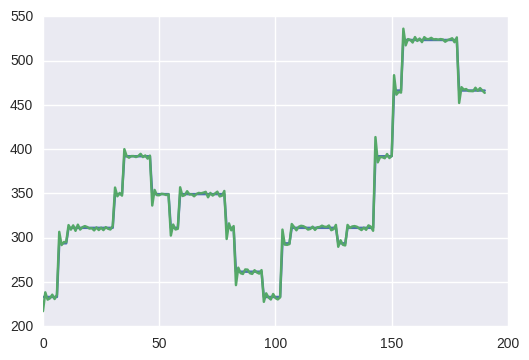

In [153]:
#################
# examine results
#################    
plt.plot(target[1:])
plt.plot(actual[1:])

# Step 6: listen
Rather than just looking at a simple graph of the simulation, we can actually listen to the simulated pitch.

In [154]:
def render_singing(notes, note_duration):
    sounds = []
    for freq in notes:
        phase = additions.get_phase(sounds[-1]) if len(sounds) > 0 else 0
        sounds.append(source.sine(freq, note_duration, phase=phase))
    sound = np.concatenate([s[:-1] for s in sounds])
    return sound

In [156]:
x = render_singing(actual, note_duration/delta)
output.play(x)